In [32]:
!pip install tensorflow==2.18.0


[notice] A new release of pip is available: 20.2.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
!pip install transformers==4.36.2

   ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
   -------- ------------------------------- 1.8/8.2 MB 14.4 MB/s eta 0:00:01
   ------------------------------------ --- 7.6/8.2 MB 23.5 MB/s eta 0:00:01
   ---------------------------------------- 8.2/8.2 MB 19.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0
    Uninstalling transformers-4.49.0:
      Successfully uninstalled transformers-4.49.0



[notice] A new release of pip is available: 20.2.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import tensorflow as tf
import transformers

print("Tensorflow version:", tf.__version__)
print("Transformers version:", transformers.__version__)

Tensorflow version: 2.15.0
Transformers version: 4.50.1


In [35]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer

In [36]:
# Load dataset
df = pd.read_csv('C:/Users/aaliy/OneDrive/Desktop/sign/NLU_dataset.csv', header=None) # Replace with the path to your dataset
df.rename(columns={0: 'input_text', 1: 'target_text'}, inplace=True)
print("Loaded Dataset:")
df

Loaded Dataset:


,input_text,target_text
0,hello you how,"Hello, how are you?"
1,you how,How are you ?
2,I name ADEEBA,My name is ADEEBA.
3,I live mumbai,I live in Mumbai.
4,how you,How are you ?
...,...,...
259,who work mumbai,Who works in Mumbai?
260,who live mumbai,Who lives in Mumbai?
261,i engineer from mumbai,I am an engineer from Mumbai.
262,I engineer mumbai,I am an engineer in Mumbai.


# New Section

In [37]:
# Ensure there are no NaNs
df.dropna(inplace=True)
unstructured_sentences = df['input_text'].tolist()
structured_sentences = df['target_text'].tolist()
print("Unstructured Sentences Example:", unstructured_sentences[:2])
print("Structured Sentences Example:", structured_sentences[:2])

Unstructured Sentences Example: ['hello you how', 'you how']
Structured Sentences Example: ['Hello, how are you?', 'How are you ?']


In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
# Pair the input and output sentences together
paired_sentences = list(zip(unstructured_sentences, structured_sentences))

# Print before shuffling
print("Before Shuffling:")
for i in range(2):
  print(f"Pair {i+1}: {paired_sentences[i]}")

# Shuffle the pairs
np.random.shuffle(paired_sentences)
# Unzip the shuffled pairs
unstructured_sentences, structured_sentences = zip(*paired_sentences)

# Print after shuffling
print("After Shuffling:")
for i in range(2):
  print(f"Pair {i+1}: Unstructured: {unstructured_sentences[i]}, Structured: {structured_sentences[i]}")

Before Shuffling:
Pair 1: ('hello you how', 'Hello, how are you?')
Pair 2: ('you how', 'How are you ?')
After Shuffling:
Pair 1: Unstructured: who you, Structured: Who are you?
Pair 2: Unstructured: how you I fine, Structured: I am fine. How are you ?


Tokenize the Data

In [39]:
# Load a pre-trained tokenizer
model_name = 't5-small'  # or any other model of your choice
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [40]:
# Tokenize the sentences
inputs = tokenizer(list(unstructured_sentences), return_tensors='tf', padding=True, truncation=True)
targets = tokenizer(list(structured_sentences), return_tensors='tf', padding=True, truncation=True)

In [41]:
# Adjust input shape
input_ids = inputs['input_ids'].numpy()
attention_mask = inputs['attention_mask'].numpy()
target_ids = targets['input_ids'].numpy()

In [42]:
# Print tokenized examples
print("Tokenized Inputs Example:", input_ids[:2])
print("Tokenized Targets Example:", target_ids[:2])

Tokenized Inputs Example: [[ 113   25    1    0    0    0    0    0    0]
 [ 149   25   27 1399    1    0    0    0    0]]
Tokenized Targets Example: [[2645   33   25   58    1    0    0    0    0    0    0    0]
 [  27  183 1399    5  571   33   25    3   58    1    0    0]]


In [43]:
# Shift target ids one step to the right
decoder_input_ids = np.concatenate([np.full((target_ids.shape[0], 1), tokenizer.pad_token_id), target_ids[:, :-1]], axis=-1)

In [44]:
# Print shifted decoder input ids example
print("Shifted Decoder Input IDs Example:", decoder_input_ids[:2])

Shifted Decoder Input IDs Example: [[   0 2645   33   25   58    1    0    0    0    0    0    0]
 [   0   27  183 1399    5  571   33   25    3   58    1    0]]


Create a TensorFlow Dataset

In [45]:
train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_decoder_input_ids, val_decoder_input_ids, train_target_ids, val_target_ids = train_test_split( input_ids,
                                                                                                                                                                              attention_mask,
                                                                                                                                                                               decoder_input_ids,
                                                                                                                                                                               target_ids,
                                                                                                                                                                               test_size=0.2,
                                                                                                                                                                               random_state=42 )

In [46]:
# Print split example
print("Training Input IDs Example:", train_input_ids[:2])
print("Validation Input IDs Example:", val_input_ids[:2])

Training Input IDs Example: [[   25  8957     1     0     0     0     0     0     0]
 [21820    27   161  9739     1     0     0     0     0]]
Validation Input IDs Example: [[21820    27   161  9739     1     0     0     0     0]
 [21820    25   149     1     0     0     0     0     0]]


In [47]:
# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_mask,
    'decoder_input_ids': train_decoder_input_ids
}, train_target_ids)).shuffle(len(train_input_ids)).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_input_ids,
    'attention_mask': val_attention_mask,
    'decoder_input_ids': val_decoder_input_ids
}, val_target_ids)).batch(8)

In [48]:
# Print dataset sizes
print("Training Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))

Training Dataset Size: 27
Validation Dataset Size: 7


Load and Configure the Model

In [49]:
# Load a pre-trained model
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [50]:
# Training configuration
training_args = {
    'epochs': 50, # Increase number of epochs
    'batch_size': 8, # Adjust batch size
    'learning_rate': 5e-5, # Adjust learning rate
    'num_beams': 4, # Beam search for inference
    'max_length': 32, # Maximum length of generated sequences
    'early_stopping': True, # Enable early stopping
    'no_repeat_ngram_size': 2 # Prevent repeating n-grams in generated sequences
}

In [ ]:
# Add learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=training_args['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9
)

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss)

In [20]:
# Print model summary
print("Model Summary:")
model.summary()

Model Summary:
Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the Model

In [21]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

ImportError: Keras cannot be imported. Check that it is installed.

In [ ]:
# Print callbacks
print("Callbacks:", callbacks)

Callbacks: [<tf_keras.src.callbacks.ModelCheckpoint object at 0x7ebf0aec5a10>, <tf_keras.src.callbacks.EarlyStopping object at 0x7ebef01be3d0>]


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=training_args['epochs'],
    callbacks=callbacks
)

Epoch 1/50
27/27 [==============================] - 77s 2s/step - loss: 6.4027 - val_loss: 2.9824
Epoch 2/50
27/27 [==============================] - 37s 1s/step - loss: 3.3833 - val_loss: 1.5390
Epoch 3/50
27/27 [==============================] - 40s 2s/step - loss: 2.2874 - val_loss: 1.1307
Epoch 4/50
27/27 [==============================] - 36s 1s/step - loss: 1.8547 - val_loss: 0.9092
Epoch 5/50
27/27 [==============================] - 42s 2s/step - loss: 1.5346 - val_loss: 0.7395
Epoch 6/50
27/27 [==============================] - 38s 1s/step - loss: 1.3148 - val_loss: 0.6316
Epoch 7/50
27/27 [==============================] - 47s 2s/step - loss: 1.1374 - val_loss: 0.5450
Epoch 8/50
27/27 [==============================] - 43s 2s/step - loss: 0.9414 - val_loss: 0.4719
Epoch 9/50
27/27 [==============================] - 37s 1s/step - loss: 0.7437 - val_loss: 0.4202
Epoch 10/50
27/27 [==============================] - 34s 1s/step - loss: 0.6275 - val_loss: 0.3762
Epoch 11/50
27/27 [

Save the Fine-Tuned Model

In [ ]:
model.save_pretrained('fine_tuned_t5(2)')
tokenizer.save_pretrained('fine_tuned_t5(2)')

('fine_tuned_t5/tokenizer_config.json',
 'fine_tuned_t5/special_tokens_map.json',
 'fine_tuned_t5/spiece.model',
 'fine_tuned_t5/added_tokens.json',
 'fine_tuned_t5/tokenizer.json')

In [ ]:
# Print training history
print("Training History:")
print(history.history)

Training History:
{'loss': [6.4623026847839355, 2.342068672180176, 1.7164145708084106, 1.2501511573791504, 0.9952083826065063, 0.7460382580757141, 0.6066402792930603, 0.49949803948402405, 0.42618313431739807, 0.3575781285762787, 0.3269058167934418, 0.30166685581207275, 0.27419596910476685, 0.236676424741745, 0.23388539254665375, 0.19490450620651245, 0.20361675322055817, 0.16500720381736755, 0.1773456484079361, 0.16755542159080505, 0.16007672250270844, 0.14556124806404114, 0.1364915817975998, 0.1331125795841217, 0.12486520409584045], 'val_loss': [1.8132318258285522, 1.1196285486221313, 0.7847696542739868, 0.5849282741546631, 0.4697285294532776, 0.3817414343357086, 0.3142448961734772, 0.26085859537124634, 0.22408200800418854, 0.19232317805290222, 0.16236728429794312, 0.1445993185043335, 0.12739711999893188, 0.11246921122074127, 0.10204506665468216, 0.09575165808200836, 0.08867056667804718, 0.08165305852890015, 0.07882799953222275, 0.07684382796287537, 0.07412595301866531, 0.0702562630176

Inference Function

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b4e1d3abd61cec1a59dffbfc55601823f4756f891e1e236bc2aca6e65d632a27
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report

# Define function to evaluate using seqeval
def evaluate_model(model, tokenizer, val_dataset):
    predictions, true_labels = [], []

    for batch in val_dataset:
        inputs = {key: value.numpy() for key, value in batch[0].items()}
        labels = batch[1].numpy()

        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=training_args['max_length'],
            num_beams=training_args['num_beams'],
            early_stopping=training_args['early_stopping'],
            no_repeat_ngram_size=training_args['no_repeat_ngram_size']
        )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Check for empty predictions and labels and handle them
        for pred, label in zip(decoded_preds, decoded_labels):
            if pred and label:  # Only add if both are non-empty
                # Tokenize predictions and labels for seqeval
                pred_tokens = pred.split()
                label_tokens = label.split()
                # Ensure tokenized sequences have the same length
                if len(pred_tokens) == len(label_tokens):
                    predictions.append(pred_tokens)
                    true_labels.append(label_tokens)
                else:
                    print(f"Skipping mismatched prediction/label lengths: pred='{pred}', label='{label}'")
            else:
                print(f"Skipping empty prediction/label: pred='{pred}', label='{label}'")

    print(classification_report(true_labels, predictions))

# Example usage
evaluate_model(model, tokenizer, val_dataset)

Skipping mismatched prediction/label lengths: pred='Engineer, good.', label='The engineer is good.'
Skipping mismatched prediction/label lengths: pred='Engineer, good.', label='The engineer is good.'
Skipping mismatched prediction/label lengths: pred='Are you from?', label='Where are you from?'
Skipping mismatched prediction/label lengths: pred='Is your name?', label='What is your name?'
              precision    recall  f1-score   support

           ?       1.00      1.00      1.00         3
     AIYYAR.       1.00      1.00      1.00         1
     AIYYAR?       1.00      1.00      1.00         1
     ALIYAH.       1.00      1.00      1.00         1
      DEEBA.       1.00      1.00      1.00         3
      DEEBA?       1.00      1.00      1.00         1
       DIBA.       1.00      1.00      1.00         1
       DIBA?       1.00      1.00      1.00         1
      HAZIL.       1.00      1.00      1.00         1
      HAZIL?       1.00      1.00      1.00         2
        UBA.  

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: am seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: fine, seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: how seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: are seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: you? seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: U

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained('/content/drive/MyDrive/A ISL-PROJ/fine_tuned_t5')
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/A ISL-PROJ/fine_tuned_t5')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/A ISL-PROJ/fine_tuned_t5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
# Function to translate unstructured sentences to structured sentences
def predict_sentence(model, sentence):
    inputs = tokenizer(sentence, return_tensors='tf', padding=True, truncation=True)
    output = model.generate(inputs['input_ids'])
    predicted_sentence = tokenizer.decode(output[0], skip_special_tokens=True)
    return predicted_sentence

# Example usage
# Example prediction
test_sentence = "i name adeeba"
print("Original:", test_sentence)
print("Predicted:", predict_sentence(model, test_sentence))
print("Prediction completed.")

Original: i name adeeba
Predicted: I name adeeba
Prediction completed.


Visualization

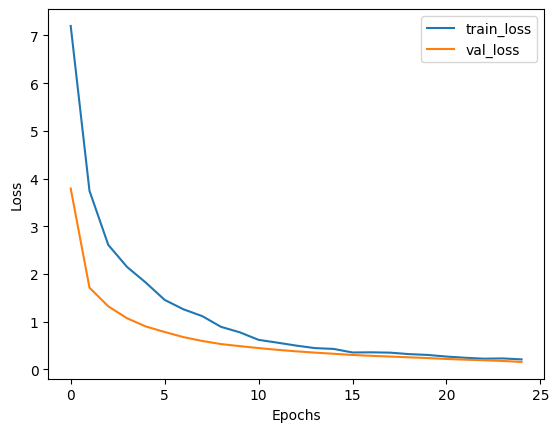

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()